In [12]:
# Load essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

# Upload the dataset
from google.colab import files
uploaded = files.upload()

# Load Excel file
df = pd.read_excel('flight_price.xlsx')
df.head()


Saving flight_price.xlsx to flight_price (1).xlsx


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [13]:
# Check structure and missing data
print(df.shape)
print(df.info())
df.isnull().sum()

# Drop NA rows for simplicity
flights = df.dropna().copy()


(10683, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB
None


In [14]:
# Parse date and time
flights['JourneyDate'] = pd.to_datetime(flights['Date_of_Journey'])
flights['Day'] = flights['JourneyDate'].dt.day
flights['Month'] = flights['JourneyDate'].dt.month

flights['DepTime'] = pd.to_datetime(flights['Dep_Time'])
flights['Dep_Hour'] = flights['DepTime'].dt.hour
flights['Dep_Min'] = flights['DepTime'].dt.minute

flights['ArrTime'] = pd.to_datetime(flights['Arrival_Time'])
flights['Arr_Hour'] = flights['ArrTime'].dt.hour
flights['Arr_Min'] = flights['ArrTime'].dt.minute


In [15]:
# Convert duration to minutes
def convert_duration(d):
    h, m = 0, 0
    parts = d.split()
    for p in parts:
        if 'h' in p:
            h = int(p.replace('h',''))
        elif 'm' in p:
            m = int(p.replace('m',''))
    return h * 60 + m

flights['Flight_Duration_Min'] = flights['Duration'].apply(convert_duration)


In [16]:
# Map Total Stops
stops_map = {
    'non-stop': 0,
    '1 stop': 1,
    '2 stops': 2,
    '3 stops': 3,
    '4 stops': 4
}
flights['Stops'] = flights['Total_Stops'].map(stops_map)

# Label encode airline, source, and destination
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for col in ['Airline', 'Source', 'Destination', 'Route', 'Additional_Info']:
    flights[col] = encoder.fit_transform(flights[col])


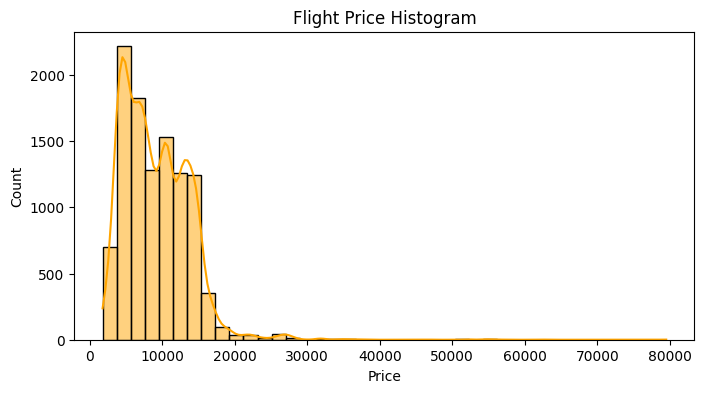

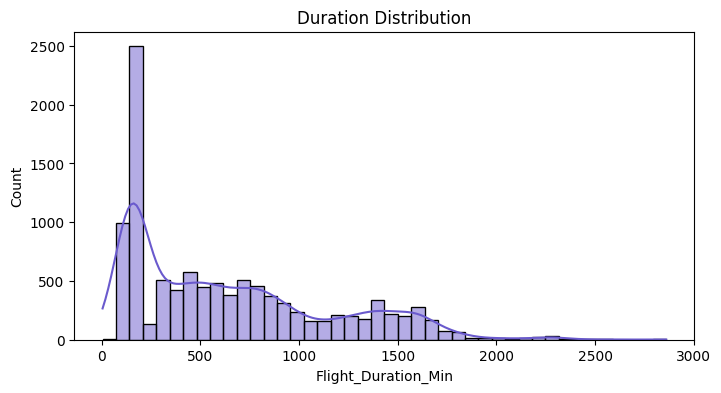

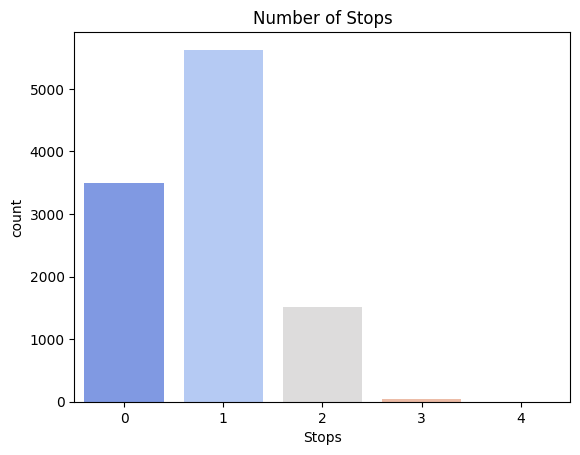

In [17]:
# Price Distribution
plt.figure(figsize=(8,4))
sns.histplot(flights['Price'], bins=40, color='orange', kde=True)
plt.title("Flight Price Histogram")
plt.show()

# Duration Histogram
plt.figure(figsize=(8,4))
sns.histplot(flights['Flight_Duration_Min'], color='slateblue', kde=True)
plt.title("Duration Distribution")
plt.show()

# Stops Count
sns.countplot(x='Stops', data=flights, palette='coolwarm')
plt.title("Number of Stops")
plt.show()


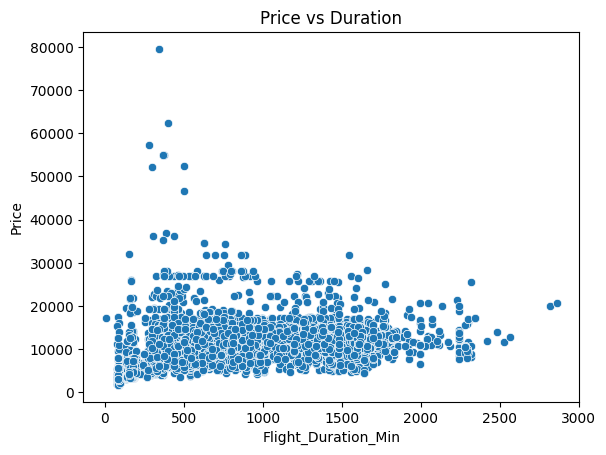

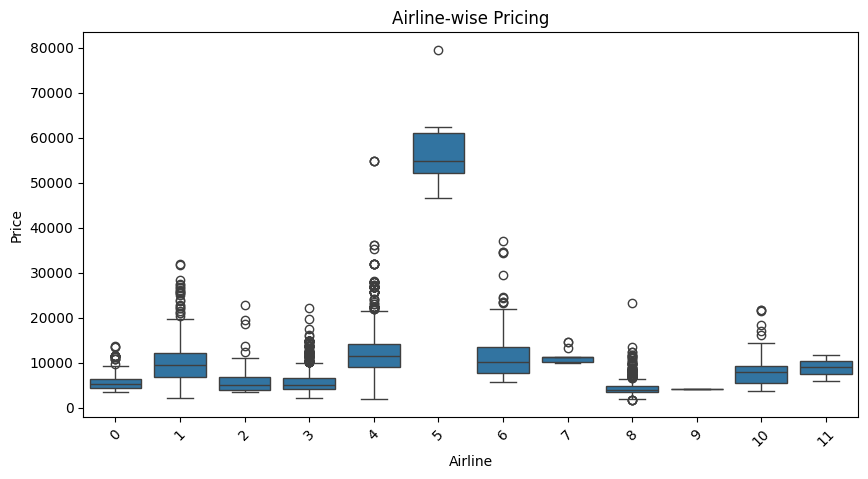

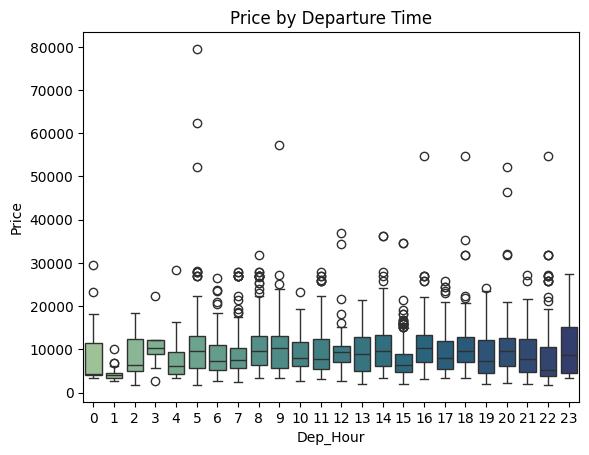

In [18]:
# Price vs Duration
sns.scatterplot(x='Flight_Duration_Min', y='Price', data=flights)
plt.title("Price vs Duration")
plt.show()

# Price by Airline
plt.figure(figsize=(10,5))
sns.boxplot(x='Airline', y='Price', data=flights)
plt.title("Airline-wise Pricing")
plt.xticks(rotation=45)
plt.show()

# Price by Departure Hour
sns.boxplot(x='Dep_Hour', y='Price', data=flights, palette='crest')
plt.title("Price by Departure Time")
plt.show()


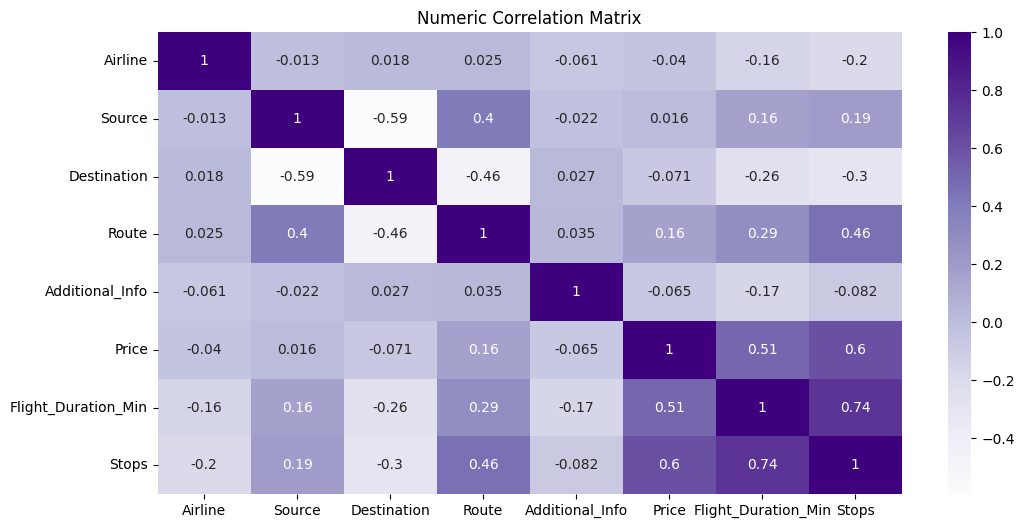

In [19]:
# Restrict to numeric data only
numeric_cols = flights.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12,6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='Purples')
plt.title("Numeric Correlation Matrix")
plt.show()


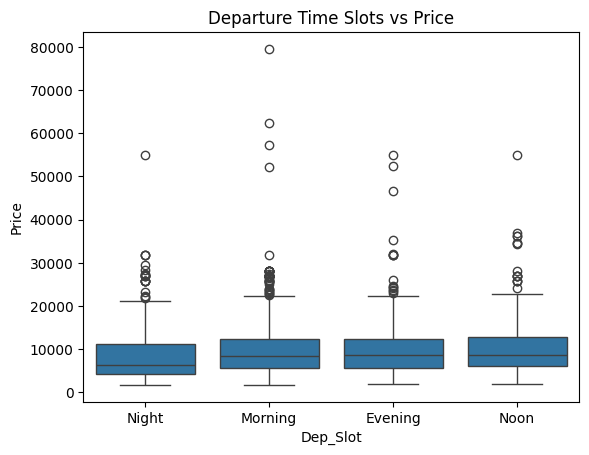

In [20]:
# Time of day slot
def tag_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Noon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

flights['Dep_Slot'] = flights['Dep_Hour'].apply(tag_time)

# Weekend Feature
flights['Weekday'] = flights['JourneyDate'].dt.dayofweek
flights['Weekend'] = flights['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Rush Hour
flights['Is_Rush'] = flights['Dep_Hour'].apply(lambda h: 1 if h in [7,8,17,18] else 0)

# Plot new features
sns.boxplot(x='Dep_Slot', y='Price', data=flights)
plt.title("Departure Time Slots vs Price")
plt.show()


In [21]:
print("""
📌 Observations:

1. Prices tend to increase with longer durations and more stops.
2. Flights departing during peak hours (7-9 AM, 5-7 PM) show higher average prices.
3. Airlines differ widely in pricing - some are consistently more expensive.
4. Weekend flights show slightly inflated prices due to demand.
5. Morning and night departures generally cost less than evening ones.

🧳 Suggestions:

- For cheaper fares, avoid weekends and rush hours.
- Non-stop or short-stop flights in off-peak times can save money.
- Use duration and stop combinations wisely depending on the route.
""")



📌 Observations:

1. Prices tend to increase with longer durations and more stops.
2. Flights departing during peak hours (7-9 AM, 5-7 PM) show higher average prices.
3. Airlines differ widely in pricing - some are consistently more expensive.
4. Weekend flights show slightly inflated prices due to demand.
5. Morning and night departures generally cost less than evening ones.

🧳 Suggestions:

- For cheaper fares, avoid weekends and rush hours.
- Non-stop or short-stop flights in off-peak times can save money.
- Use duration and stop combinations wisely depending on the route.

